In [7]:
cases = [0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 6, 6, 6, 9, 9, 15, 19, 24, 33, 33, 53, 56, 86, 98, 131, 137, 191, 262, 290, 410, 546, 703, 817, 1014, 1226, 1613, 1880, 2475, 2923, 3357, 3893, 4484, 5181, 5841, 6698, 7822, 8852, 10158, 11513, 13002, 14776, 16146, 18105, 20754, 24324, 26350, 29433, 31981, 33940, 36897, 39509, 42480, 45351, 48426, 50646, 53739, 57300, 62658, 68606, 74401, 80115, 85973, 92676, 98522]

In [8]:
# importing required modules

import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import odeint

# setting plot parameters

plt.ion()
plt.rcParams['figure.figsize'] = 10, 8

In [187]:
# setting known disease parameters

sigma = 5.1 # mean incubation period
eta = 3.5 # avg time between symptoms and hospitalization
delta = 14.68 # avg time between hospitalization and death
gamma = 11.36 # avg curation time (with symptoms)
lmbda = 11.36 # avg curation time (no symptoms)
mu = 0.88 # amount of non-symptom cases
xi = 3 # mean time between end of incub. period and detection of a virus

На данный момент неизвестны два параметра:


1) $\beta$ — infection rate


2) $\rho$ — mortality rate

Предлагается разбить наблюдаемый период на группы. 

Будем считать, что 24.02.2020
в Москве появился первый заболевший $\in \text { } Infectious$

(27.02 он обратился за мед. помощью, среднее время
от конца инкуб. периода до выявления вируса = 3 дня)

Таким образом, наблюдается период с 24.02 до 8.05. 

31.03 в Москве была введена самоизоляция, это одна из ключевых дат. 

Так, период разбивается на два: с 24.02 до 30.03 и с 31.03 до 8.05.

Первый период разобьём на 2 2.5-недельных промежутка.

Второй период разобьём также на 2 2-недельных промежутка (таким образом, последний закончится 5 мая)

Для каждого из промежутков при помощи метода наименьших квадратов аппроксимируем $\beta \text{ и } \rho$

Далее построим для каждого из параметров линейную регрессию, и с полученными значениями $\beta \text{ и } \rho$ дадим прогноз на период начиная с 6-ого марта

Первые две недели посчитаем вместе, потому что там было маленькое количество тестов. Если фиттить по неделям, есть шанс получить beta = 0 в самом начале (и, соответственно, вымирание эпидемии, что не произошло)

In [138]:
# defining the system of ODE 

def f(y, t, beta, rho):
    Xi = y[0] # susceptible
    Vi = y[1] # exposed
    Qi = y[2] # infectious
    Wi = y[3] # non-symptomatical
    Yi = y[4] # symptomatical (non-hospitalized)
    Ui = y[5] # hospitalized
    Zi = y[6] # removed
    Di = y[7] # dead
    f0 = -beta * Xi * Qi / N
    f1 = beta * Xi * Qi / N - (1 / sigma) * Vi
    f2 = (1 / sigma) * Vi - (1 / xi) * Qi
    f3 = (1 / xi) * mu * Qi - (1 / lmbda) * Wi
    f4 = (1 / xi) * (1 - mu) * Qi - 0.87 * (1 / gamma) * Yi - 0.13 * (1 / eta) * Yi
    f5 = 0.13 * (1 / eta) * Yi - (1 / gamma) * Ui / (1 - rho)
    f6 = (1 / lmbda) * Wi + 0.87 * (1 / gamma) * Yi + (1 / gamma) * Ui
    f7 = rho / (1 - rho) * Ui
    return [f0, f1, f2, f3, f4, f5, f6, f7]


# implementing error func
# cases is a 1D-array containing info about reported cases during the period
# inp is a 1-D array containing initial state of the system
from functools import partial

def error(b, r, cases, inp):
    err = 0
    t = np.linspace(0, 16, 70 * 16)
    f2 = partial(f, beta=b, rho=r)
    soln = odeint(f2, inp, t)
    W = soln[:, 3]
    Y = soln[:, 4]
    U = soln[:, 5]
    Z = soln[:, 6]
    for i in range(1, 17):
        forecast_cases = W[i * 70 - 1] + Y[i * 70 - 1] + U[i * 70 - 1] + Z[i * 70 - 1]
        to_sum = (forecast_cases - cases[i - 1]) ** 2
        err += to_sum
    return err

Запустим перебор по значениям $\beta \text{ и } \rho$ с шагом 0.01

Будем считать, что $\beta \in [0.4, 1.5]; \rho \in [0.5, 1]$

In [33]:
def fit_beta(week, inp):

    best_beta = 0
    best_error = 10e6
    for i in range(40, 400):
        beta = i / 100
        current_beta_error= error(beta, 0.8, cases[int(week * 7):int(week*7) + 17], inp)
        if current_beta_error < best_error:
            best_beta = beta
            best_error = current_beta_error
    return best_beta, best_error

In [34]:
N = 12537954 # moscow population 
X_0 = N - 1
V_0 = 0
Q_0 = 1
W_0 = 0
Y_0 = 0
U_0 = 0
Z_0 = 0
D_0 = 0
y0 = [X_0, V_0, Q_0, W_0, Y_0, U_0, Z_0, D_0]
x, err = fit_beta(0, y0)
print(x, err)

0.82 33.66392424765252


In [35]:
t = np.linspace(0, 16, 70 * 16)
f2 = partial(f, beta=0.82, rho=0.8)
soln = odeint(f2, y0, t)

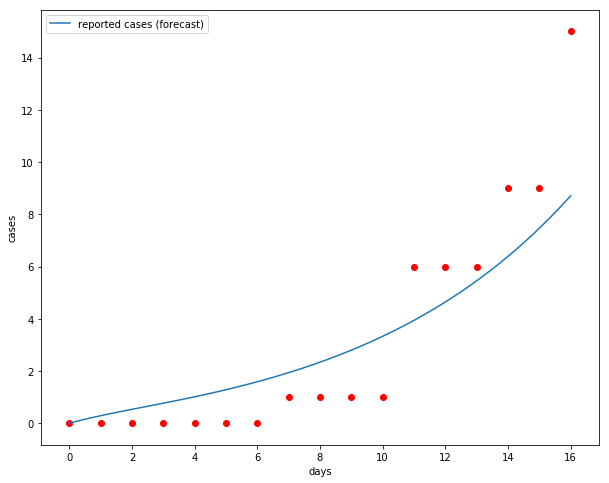

In [36]:
X_1 = soln[:, 0]
V_1 = soln[:, 1]
Q_1 = soln[:, 2]
W_1 = soln[:, 3]
Y_1 = soln[:, 4]
U_1 = soln[:, 5]
Z_1 = soln[:, 6]
D_1 = soln[:, 7]
plt.plot(t, W_1 + Y_1 + U_1 + Z_1, label='reported cases (forecast)')
plt.xlabel('days')
plt.ylabel('cases')
plt.legend(loc=0)
for i in range(17):
    plt.scatter(i, cases[i], color='red')

In [37]:
y1 = [X_1[70*16-1], V_1[70*16-1], Q_1[70*16-1], W_1[70*16-1], Y_1[70*16-1], U_1[70*16-1], Z_1[70*16-1], D_1[70*16-1]]
x2, err2 = fit_beta(17/7, y1)
print(x2, err2)

1.83 20123.03629773521


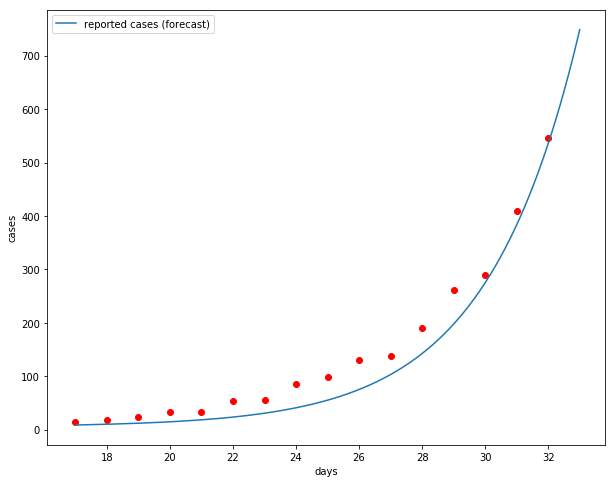

In [41]:
t = np.linspace(17, 33, 70 * 16)
f2 = partial(f, beta=1.83, rho=0.8)
soln2 = odeint(f2, y1, t)
X_2 = soln2[:, 0]
V_2 = soln2[:, 1]
Q_2 = soln2[:, 2]
W_2 = soln2[:, 3]
Y_2 = soln2[:, 4]
U_2 = soln2[:, 5]
Z_2 = soln2[:, 6]
D_2 = soln2[:, 7]
plt.plot(t, W_2 + Y_2 + U_2 + Z_2, label='reported cases (forecast)')
plt.xlabel('days')
plt.ylabel('cases')
plt.legend(loc=0)
for i in range(17, 33):
    plt.scatter(i, cases[i], color='red')

In [44]:
y2 = [X_2[70*16-1], V_2[70*16-1], Q_2[70*16-1], W_2[70*16-1], Y_2[70*16-1], U_2[70*16-1], Z_2[70*16-1], D_2[70*16-1]]
x2, err2 = fit_beta(34/7, y2)
print(x2, err2)

0.55 2112120.2966092834


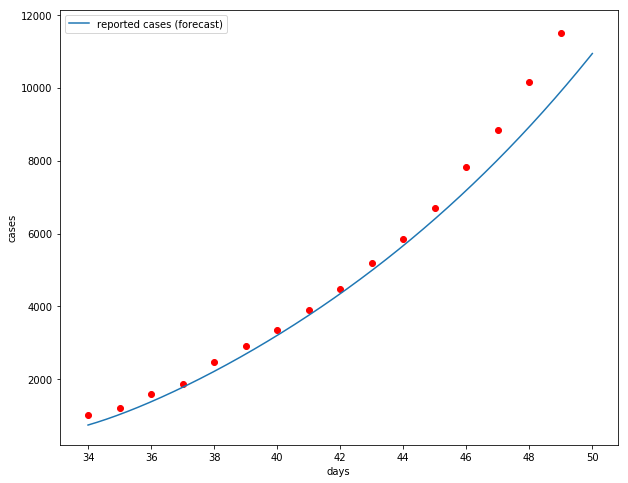

In [46]:
t = np.linspace(34, 50, 70 * 16)
f2 = partial(f, beta=0.55, rho=0.8)
soln3 = odeint(f2, y2, t)
X_3 = soln3[:, 0]
V_3 = soln3[:, 1]
Q_3 = soln3[:, 2]
W_3 = soln3[:, 3]
Y_3 = soln3[:, 4]
U_3 = soln3[:, 5]
Z_3 = soln3[:, 6]
D_3 = soln3[:, 7]
plt.plot(t, W_3 + Y_3 + U_3 + Z_3, label='reported cases (forecast)')
plt.xlabel('days')
plt.ylabel('cases')
plt.legend(loc=0)
for i in range(34, 50):
    plt.scatter(i, cases[i], color='red')

In [183]:
betas = list()
for i in range(4):
    if i == 0:
        x, err = fit_beta_1stp(0, y0)
        t = np.linspace(0, 13, 490 * 2)
        soln = odeint(partial(f, beta=x, rho=0.8), y0, t)
        y0 = [soln[:, 0][979], soln[:, 1][979], soln[:, 2][979], soln[:, 3][979], soln[:, 4][979], soln[:, 5][979], soln[:, 6][979], soln[:, 7][979]]
        betas.append(x)
    else:
        x, err = fit_beta(i + 1, y0)
        t = np.linspace(0, 6, 490 * 2)
        soln = odeint(partial(f, beta=x, rho=0.8), y0, t)
        y0 = [soln[:, 0][979], soln[:, 1][979], soln[:, 2][979], soln[:, 3][979], soln[:, 4][979], soln[:, 5][979], soln[:, 6][979], soln[:, 7][979]]
        betas.append(x)
    print("Step number {}: beta = {}, error = {}\n".format(i + 1, x, err))

Step number 1: beta = 0.82, error = 27.387040146043972

Step number 2: beta = 3.49, error = 214.7195272904078

Step number 3: beta = 0.2, error = 9794.572927843734

Step number 4: beta = 3.03, error = 42202.933523594125



Какая-то неадекватная хуйня. Я устал, завтра разберусь

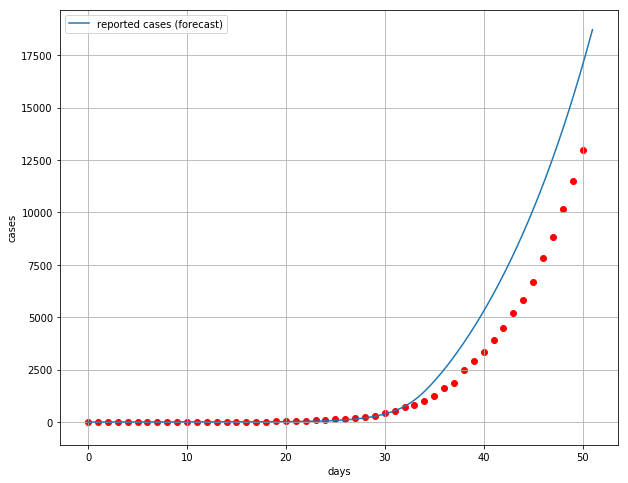

In [53]:
def f_graph(y, t):
    if t <= 16:
        beta = 0.82
    elif t <= 33:
        beta = 1.83
    else:
        beta = 0.55
    rho = 0.4
    Xi = y[0] # susceptible
    Vi = y[1] # exposed
    Qi = y[2] # infectious
    Wi = y[3] # non-symptomatical
    Yi = y[4] # symptomatical (non-hospitalized)
    Ui = y[5] # hospitalized
    Zi = y[6] # removed
    Di = y[7] # dead
    f0 = -beta * Xi * Qi / N
    f1 = beta * Xi * Qi / N - (1 / sigma) * Vi
    f2 = (1 / sigma) * Vi - (1 / xi) * Qi
    f3 = (1 / xi) * mu * Qi - (1 / lmbda) * Wi
    f4 = (1 / xi) * (1 - mu) * Qi - 0.87 * (1 / gamma) * Yi - 0.13 * (1 / eta) * Yi
    f5 = 0.13 * (1 / eta) * Yi - (1 / gamma) * Ui / (1 - rho)
    f6 = (1 / lmbda) * Wi + 0.87 * (1 / gamma) * Yi + (1 / gamma) * Ui
    f7 = rho / (1 - rho) * Ui
    return [f0, f1, f2, f3, f4, f5, f6, f7]
t = np.linspace(0, 51, 490 * 5)
soln = odeint(f_graph, y0, t)
X = soln[:, 0]
V = soln[:, 1]
Q = soln[:, 2]
W = soln[:, 3]
Y = soln[:, 4]
U = soln[:, 5]
Z = soln[:, 6]
D = soln[:, 7]
plt.plot(t, W + Y + U + Z, label='reported cases (forecast)')
plt.xlabel('days')
plt.ylabel('cases')
plt.legend(loc=0)
for i in range(51):
    plt.scatter(i, cases[i], color='red')
plt.grid(True)

In [54]:
len(cases)

75

In [164]:
def error(a, b):
    error = 0
    best_beta = None
    y0 = [N - 1, 0, 1, 0, 0, 0, 0, 0]
    for i in range(70):
        beta = a * i + b
        f2 = partial(f, beta=beta, rho=0.5)
        t = np.linspace(i, i + 1, 70)
        soln = odeint(f2, y0, t)
        X = soln[:, 0]
        V = soln[:, 1]
        Q = soln[:, 2]
        W = soln[:, 3]
        Y = soln[:, 4]
        U = soln[:, 5]
        Z = soln[:, 6]
        D = soln[:, 7]
        to_sum = W[69] + Y[69] + U[69] + Z[69] - cases[i]
        error += to_sum * to_sum
        y0 = [X[69], V[69], Q[69], W[69], Y[69], U[69], Z[69], D[69]]
    return error

In [69]:
print(error(1, 1))

6634294688622583.0


In [70]:
step = 0.01
min_b = 0.3
max_b = 2
max_a = -0.01
min_a = -1.7
best_error = 10e12
best_params = None
a = min_a
while (a <= max_a):
    b = min_b
    while (b <= max_b):
        new_err = error(a, b)
        if new_err < best_error:
            best_error = new_err
            best_params = [a, b]
        b += step
    print("a = {} done".format(a))
    a += step

a = -1.7 done
a = -1.69 done
a = -1.68 done
a = -1.67 done
a = -1.66 done
a = -1.65 done
a = -1.64 done
a = -1.63 done
a = -1.6199999999999999 done
a = -1.6099999999999999 done
a = -1.5999999999999999 done
a = -1.5899999999999999 done
a = -1.5799999999999998 done
a = -1.5699999999999998 done
a = -1.5599999999999998 done
a = -1.5499999999999998 done
a = -1.5399999999999998 done
a = -1.5299999999999998 done
a = -1.5199999999999998 done
a = -1.5099999999999998 done
a = -1.4999999999999998 done
a = -1.4899999999999998 done
a = -1.4799999999999998 done
a = -1.4699999999999998 done
a = -1.4599999999999997 done
a = -1.4499999999999997 done
a = -1.4399999999999997 done
a = -1.4299999999999997 done
a = -1.4199999999999997 done
a = -1.4099999999999997 done
a = -1.3999999999999997 done
a = -1.3899999999999997 done
a = -1.3799999999999997 done
a = -1.3699999999999997 done
a = -1.3599999999999997 done
a = -1.3499999999999996 done
a = -1.3399999999999996 done
a = -1.3299999999999996 done
a = -1.3199

In [72]:
print(best_error, best_params)

465789173.5977191 [-0.01999999999999858, 1.5000000000000009]


In [73]:
a = -0.01
b = min_b
while (b <= max_b):
    new_err = error(a, b)
    if new_err < best_error:
        best_error = new_err
        best_params = [a, b]
    b += step

In [74]:
print(best_error, best_params)

465789173.5977191 [-0.01999999999999858, 1.5000000000000009]


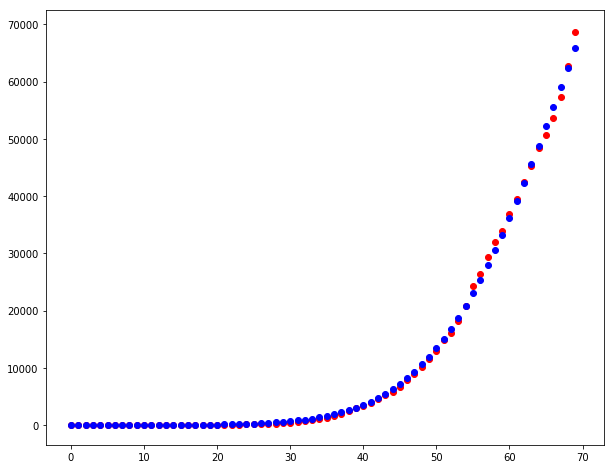

In [284]:
y0 = [N - 1, 0, 1, 0, 0, 0, 0, 0]
forecast = list()
for i in range(len(cases) + 15):
    xi = 3
    beta = -0.015920000000000045 * i + 1.3889999999999958
    f2 = partial(f, beta=beta, rho=0.5)
    t = np.linspace(i, i + 1, 70)
    soln = odeint(f2, y0, t)
    X = soln[:, 0]
    V = soln[:, 1]
    Q = soln[:, 2]
    W = soln[:, 3]
    Y = soln[:, 4]
    U = soln[:, 5]
    Z = soln[:, 6]
    D = soln[:, 7]
    y0 = [X[69], V[69], Q[69], W[69], Y[69], U[69], Z[69], D[69]]
    if i < 70:
        plt.scatter(i, cases[i], color='red')
        plt.scatter(i, W[69] + Y[69] + U[69] + Z[69], color='blue')
    else:
        forecast.append(W[69] + Y[69] + U[69] + Z[69])
plt.show()

In [277]:
print(forecast)

[74317.24259008844, 81183.12901073534, 88657.82038925562, 96793.96613762039, 105648.51968680145, 115283.04395306125, 125764.02963952583, 137163.2250622132, 149557.97569602382, 163031.57105173834, 177673.5958092577, 193580.28133451747, 210854.85278767548, 229607.86597936996, 249957.5269431601, 272029.98586188245, 295959.59551410575, 321889.12280080107, 349969.90018639446, 380361.90206726745]


In [278]:
print(cases[70:])

[74401, 80115, 85973, 92676, 98522]


In [166]:
a_step = 0.00001
b_step = 0.001
min_b = 1.35
max_b = 1.51
max_a = -0.0156
min_a = -0.0170
best_error = 10e12
best_params = None
a = min_a
while (a <= max_a):
    b = min_b
    while (b <= max_b):
        new_err = error(a, b)
        if new_err < best_error:
            best_error = new_err
            best_params = [a, b]
        b += b_step
    print("a = {} done".format(a))
    a += a_step

a = -0.017 done
a = -0.01699 done
a = -0.016980000000000002 done
a = -0.016970000000000002 done
a = -0.016960000000000003 done
a = -0.016950000000000003 done
a = -0.016940000000000004 done
a = -0.016930000000000004 done
a = -0.016920000000000004 done
a = -0.016910000000000005 done
a = -0.016900000000000005 done
a = -0.016890000000000006 done
a = -0.016880000000000006 done
a = -0.016870000000000007 done
a = -0.016860000000000007 done
a = -0.016850000000000007 done
a = -0.016840000000000008 done
a = -0.016830000000000008 done
a = -0.01682000000000001 done
a = -0.01681000000000001 done
a = -0.01680000000000001 done
a = -0.01679000000000001 done
a = -0.01678000000000001 done
a = -0.01677000000000001 done
a = -0.01676000000000001 done
a = -0.01675000000000001 done
a = -0.016740000000000012 done
a = -0.016730000000000012 done
a = -0.016720000000000013 done
a = -0.016710000000000013 done
a = -0.016700000000000013 done
a = -0.016690000000000014 done
a = -0.016680000000000014 done
a = -0.016670

In [169]:
print(best_error, best_params)

28219343.267033733 [-0.015920000000000045, 1.3889999999999958]


643.8544510048151


In [233]:
def f(y, t, beta, rho):
    Xi = y[0] # susceptible
    Vi = y[1] # exposed
    Qi = y[2] # infectious
    Wi = y[3] # non-symptomatical
    Yi = y[4] # symptomatical (non-hospitalized)
    Ui = y[5] # hospitalized
    Zi = y[6] # removed
    Di = y[7] # dead
    f0 = -beta * Xi * Qi / N
    f1 = beta * Xi * Qi / N - (1 / sigma) * Vi
    f2 = (1 / sigma) * Vi - (1 / xi) * Qi
    f3 = (1 / xi) * mu * Qi - (1 / lmbda) * Wi
    f4 = (1 / xi) * (1 - mu) * Qi - 0.87 * (1 / gamma) * Yi - 0.13 * (1 / eta) * Yi
    f5 = 0.13 * (1 / eta) * Yi - (1 / gamma) * Ui / (1 - rho)
    f6 = (1 / lmbda) * Wi + 0.87 * (1 / gamma) * Yi + (1 / gamma) * Ui
    f7 = rho / (1 - rho) * Ui
    return [f0, f1, f2, f3, f4, f5, f6, f7]

    


# xi = a*t+b

def xi_error(c, d):
    error = 0
    y0 = [N - 1, 0, 1, 0, 0, 0, 0, 0]
    for i in range(70):
        beta = -0.0159999999999997 * i + 1.3909999999999
        xi = c * i + d
        if xi == 0:
            return 10e12
        f3 = partial(f, beta=beta, rho=0.5, xi=xi)
        t = np.linspace(i, i + 1, 70)
        soln = odeint(f3, y0, t)
        X = soln[:, 0]
        V = soln[:, 1]
        Q = soln[:, 2]
        W = soln[:, 3]
        Y = soln[:, 4]
        U = soln[:, 5]
        Z = soln[:, 6]
        D = soln[:, 7]
        to_sum = W[69] + Y[69] + U[69] + Z[69] - cases[i]
        error += to_sum * to_sum
        y0 = [X[69], V[69], Q[69], W[69], Y[69], U[69], Z[69], D[69]]
    return error

In [215]:
c_min = -2
c_max = -0.01
d_min = 1.5
d_max = 5
c = c_min
best_error_xi = 10e12
best_params_xi = None
while (c <= c_max):
    d = d_min
    while (d <= d_max):
        current = xi_error(c,d)
        if current < best_error_xi:
            best_error_xi = current
            best_params_xi = [c, d]
        d += 0.1
    print("c = {} done".format(c))
    c += 0.01

c = -2 done
c = -1.99 done
c = -1.98 done
c = -1.97 done


/Users/danyasedashov/anaconda3/lib/python3.7/site-packages/scipy/integrate/odepack.py:248: ODEintWarning: Repeated convergence failures (perhaps bad Jacobian or tolerances). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


c = -1.96 done
c = -1.95 done
c = -1.94 done
c = -1.93 done
c = -1.92 done
c = -1.91 done
c = -1.9 done
c = -1.89 done
c = -1.88 done
c = -1.8699999999999999 done
c = -1.8599999999999999 done
c = -1.8499999999999999 done
c = -1.8399999999999999 done
c = -1.8299999999999998 done
c = -1.8199999999999998 done
c = -1.8099999999999998 done
c = -1.7999999999999998 done
c = -1.7899999999999998 done
c = -1.7799999999999998 done
c = -1.7699999999999998 done
c = -1.7599999999999998 done
c = -1.7499999999999998 done
c = -1.7399999999999998 done
c = -1.7299999999999998 done
c = -1.7199999999999998 done
c = -1.7099999999999997 done
c = -1.6999999999999997 done
c = -1.6899999999999997 done
c = -1.6799999999999997 done
c = -1.6699999999999997 done
c = -1.6599999999999997 done
c = -1.6499999999999997 done
c = -1.6399999999999997 done


/Users/danyasedashov/anaconda3/lib/python3.7/site-packages/scipy/integrate/odepack.py:248: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


c = -1.6299999999999997 done
c = -1.6199999999999997 done
c = -1.6099999999999997 done
c = -1.5999999999999996 done
c = -1.5899999999999996 done
c = -1.5799999999999996 done
c = -1.5699999999999996 done
c = -1.5599999999999996 done
c = -1.5499999999999996 done
c = -1.5399999999999996 done
c = -1.5299999999999996 done
c = -1.5199999999999996 done
c = -1.5099999999999996 done
c = -1.4999999999999996 done
c = -1.4899999999999995 done
c = -1.4799999999999995 done
c = -1.4699999999999995 done
c = -1.4599999999999995 done
c = -1.4499999999999995 done
c = -1.4399999999999995 done
c = -1.4299999999999995 done
c = -1.4199999999999995 done
c = -1.4099999999999995 done
c = -1.3999999999999995 done
c = -1.3899999999999995 done
c = -1.3799999999999994 done
c = -1.3699999999999994 done
c = -1.3599999999999994 done
c = -1.3499999999999994 done
c = -1.3399999999999994 done
c = -1.3299999999999994 done
c = -1.3199999999999994 done
c = -1.3099999999999994 done
c = -1.2999999999999994 done
c = -1.2899999

In [216]:
print(best_error_xi, best_params_xi)

292373991.02834064 [-0.01999999999999836, 3.5000000000000018]


In [167]:
print("step = {}, err ={}, a ={},, b = {}".format(0.001, 29018398.785509832, -0.0159999999999997, 1.39099999999999))

step = 0.001, err =29018398.785509832, a =-0.0159999999999997,, b = 1.39099999999999


In [168]:
print("step = {}, err ={}, a ={},, b = {}".format(0.01, 465789173.5977191, -0.01999999999999858, 1.5000000000000009))

step = 0.01, err =465789173.5977191, a =-0.01999999999999858,, b = 1.5000000000000009


In [170]:
print("step = {}, err ={}, a ={},, b = {}".format(0.0001, 28219343.267033733, -0.015920000000000045, 1.3889999999999958))

step = 0.0001, err =28219343.267033733, a =-0.015920000000000045,, b = 1.3889999999999958
